# Motion Recognition with SNNs
some intro, link to dataset_showcase, 

TODO
- README
## 1. Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
from snntorch import functional as SF

import wandb
import lightning as L
import torchsummary
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from utils import create_sample, make_event_based, animate, spiking_overview

## 2. Set variables

In [2]:
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


## 3. Parameters

In [27]:
config = {
    "dataset": {
        "n_samples": 32000,
        "shapes_train": ('square', 'circle'),
        "shapes_test": ('square', 'circle'),
        "frame_size": 64,
        "n_frames": 16,
    },
    "epochs": 1,
    "population": 5,
    "conv_layers": {
        "input_channels": (1, 16),
        "output_channels": (16, 32),
        "kernel_sizes": (3, 3),
        "paddings": ("same", "same")
    },
    "max_pool_layers": {
        "kernel_sizes": (2, 2),
        "strides": (2, 2)
    },
    "leaky_layers": {
        "betas": (0.95, 0.95, 0.95),
        "learn_betas": (False, False, False)
    },
    "fc_layer": {
        "input_channels": 16*16*32,
        "output_channels": 5
    },
    "optimizer": {
        "lr": 1e-2,
        "betas": (0.9, 0.999)
    }
}

## 4. Visualize data
Just a gif

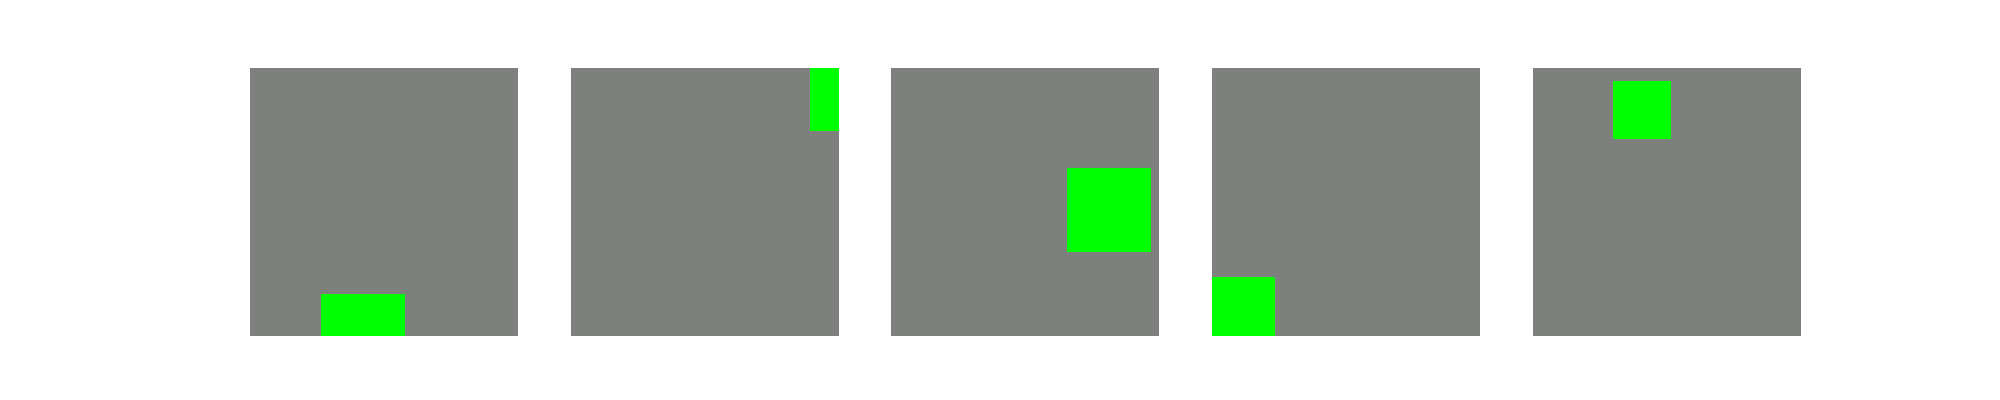

In [28]:
shape = "square"
motions = ["up", "down", "left", "right", "rotation"]
frames_list = []
labels_list = []
for motion in motions:
    frames, labels = create_sample(shape, motion, config["dataset"]["frame_size"], config["dataset"]["n_frames"])
    frames_list.append(frames)
    labels_list.append(labels)

animate(frames_list, "all_motions.gif")

<center> Figure 4.1: All motions in normal format</center>

Now we convert it to events

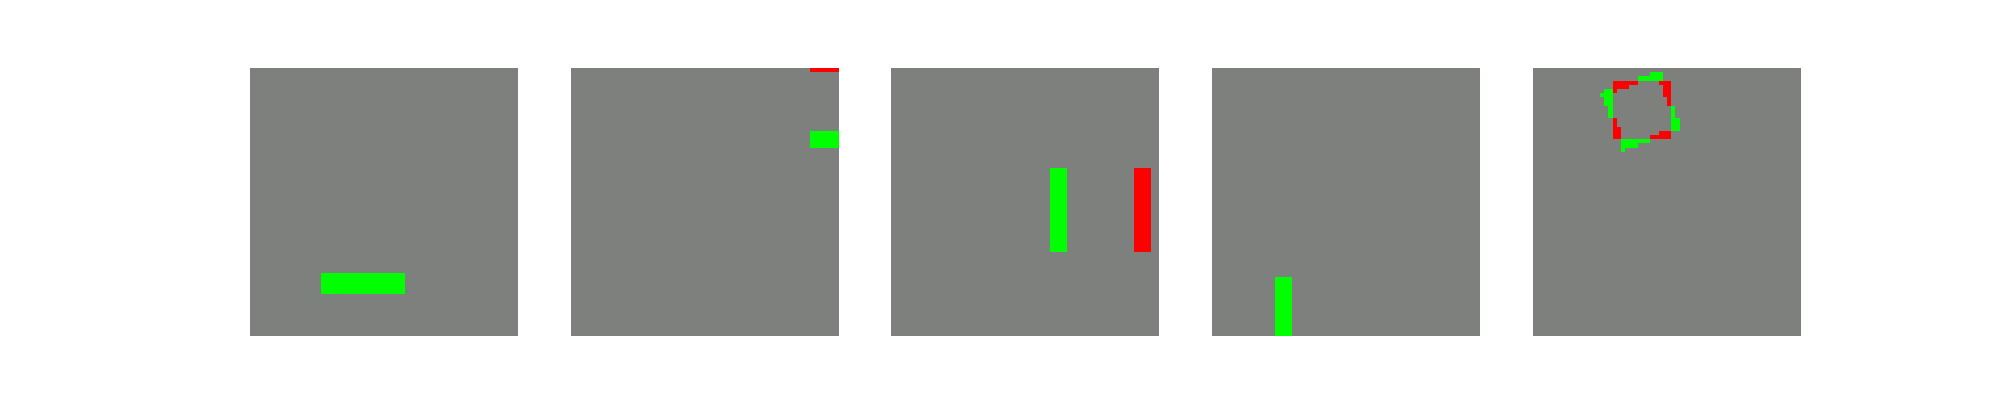

In [29]:
events_list = []
for frames in frames_list:
    events = make_event_based(frames)
    events_list.append(events)
    
animate(events_list, "all_motions_events.gif")

<center> Figure 4.2: All motions in event-based format</center>

## 5. Create dataloaders

In [30]:
class EventBasedDataset(Dataset):
    def __init__(self, samples, config, split):
        self.samples = samples
        self.config = config
        self.split = split

    def __len__(self):
        return self.samples


    def __getitem__(self, idx):
        if self.split == "train" or self.split == "val":
          shape = np.random.choice(self.config["dataset"]["shapes_train"])
        if self.split == "test":
          shape = np.random.choice(self.config["dataset"]["shapes_test"])
        motion = np.random.choice(["up", "down", "left", "right", "rotation"])
        frames, label = create_sample(shape, motion, self.config["dataset"]["frame_size"], self.config["dataset"]["n_frames"])
        events = make_event_based(frames)
        return torch.from_numpy(events).type(torch.float32), torch.tensor(label, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = EventBasedDataset(config["dataset"]["n_samples"], config, "train")
val_dataset = EventBasedDataset(config["dataset"]["n_samples"]//7, config, "val")
test_dataset = EventBasedDataset(config["dataset"]["n_samples"]//10, config, "test")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 6. The model

In [31]:
class LightningConvNet(L.LightningModule):
    def __init__(self, config):
        super().__init__()

        self.save_hyperparameters(config)

        self.conv1 = nn.Conv2d(self.hparams.conv_layers["input_channels"][0], self.hparams.conv_layers["output_channels"][0], kernel_size=self.hparams.conv_layers["kernel_sizes"][0], padding=self.hparams.conv_layers["paddings"][0])
        self.lif1 = snn.Leaky(beta=self.hparams.leaky_layers["betas"][0], learn_beta=self.hparams.leaky_layers["learn_betas"][0])
        self.pool1 = nn.MaxPool2d(kernel_size=self.hparams.max_pool_layers["kernel_sizes"][0], stride=self.hparams.max_pool_layers["strides"][0])

        self.conv2 = nn.Conv2d(self.hparams.conv_layers["input_channels"][1], self.hparams.conv_layers["output_channels"][1], kernel_size=self.hparams.conv_layers["kernel_sizes"][1], padding=self.hparams.conv_layers["paddings"][1])
        self.lif2 = snn.Leaky(beta=self.hparams.leaky_layers["betas"][1], learn_beta=self.hparams.leaky_layers["learn_betas"][1])
        self.pool2 = nn.MaxPool2d(kernel_size=self.hparams.max_pool_layers["kernel_sizes"][1], stride=self.hparams.max_pool_layers["strides"][1])

        self.fc1 = nn.Linear(self.hparams.fc_layer["input_channels"], self.hparams.fc_layer["output_channels"]*self.hparams.population)
        self.lif3 = snn.Leaky(beta=self.hparams.leaky_layers["betas"][2], learn_beta=self.hparams.leaky_layers["learn_betas"][2])

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk1_rec = []
        mem1_rec = []

        spk2_rec = []
        mem2_rec = []

        spk3_rec = []
        mem3_rec = []

        # (B, T, H, W) -> (B, C, T, H, W) where C = 1
        if len(x.shape) == 4:
            x = x.unsqueeze(1)
            steps = x.shape[2]
        # (T, H, W) -> (B, C, T, H, W) where B = C = 1
        if len(x.shape) == 3:
            x = x.unsqueeze(0).unsqueeze(0)
            steps = x.shape[2]

        for step in range(steps):
            # print(x.shape, "x")
            x_step = x[:, :, step]
            # print(x_step.shape, "x_step")

            cur1 = self.conv1(x_step)
            # print(cur1.shape, "cur1")
            spk1, mem1 = self.lif1(self.pool1(cur1), mem1)
            # print(spk1.shape, "spk1")
            # print(mem1.shape, "mem1")
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            cur2 = self.conv2(spk1)
            # print(cur2.shape, "cur2")
            spk2, mem2 = self.lif2(self.pool2(cur2), mem2)
            # print(spk2.shape, "spk2")
            # print(mem2.shape, "mem2")
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            cur3 = self.fc1(spk2.flatten(1))
            # print(cur3.shape, "cur3")
            spk3, mem3 = self.lif3(cur3, mem3)
            # print(spk3.shape, "spk3")
            # print(mem3.shape, "mem3")
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)

    def common_step(self, batch, batch_idx, split):
        data, targets = batch
        spk_rec, _, _, _, _, _ = self(data)
        print(spk_rec.shape)
        if self.hparams.population == 1:
            loss = nn.CrossEntropyLoss()
            loss_val = loss(spk_rec.sum(0), targets)
            acc = (spk_rec.sum(0).argmax(-1) == targets).float().mean()
        else:
            loss = SF.ce_count_loss(population_code=True, num_classes=5)
            loss_val = loss(spk_rec, targets)
            spk_rec_reshaped = spk_rec.view(-1, 32, 5, self.hparams.population)
            print(spk_rec_reshaped.shape)
            spr_rec_summed = spk_rec_reshaped.sum(-1)
            print(spr_rec_summed.shape)
            acc = (spr_rec_summed.sum(0).argmax(-1) == targets).float().mean()

        # logging
        self.log(f"{split}/loss", loss_val)
        self.log(f"{split}/acc", acc)

        return loss_val

    def training_step(self, batch, batch_idx):
        loss_val = self.common_step(batch, batch_idx, "train")
        return loss_val

    def validation_step(self, batch, batch_idx):
        loss_val = self.common_step(batch, batch_idx, "val")
        return loss_val

    def test_step(self, batch, batch_idx):
        loss_val = self.common_step(batch, batch_idx, "test")
        return loss_val

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.optimizer["lr"], betas=self.hparams.optimizer["betas"])
        return optimizer

wandb_logger = WandbLogger(project="SNN-motion-recognition")
trainer = L.Trainer(max_epochs=config["epochs"], logger=wandb_logger, callbacks=[EarlyStopping(monitor="val/loss", mode="min", patience=5)])
model = LightningConvNet(config)
# torchsummary.summary(model, (config["dataset"]["n_frames"], config["dataset"]["frame_size"], config["dataset"]["frame_size"]))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## 7. Train

In [32]:
train = True
save = False

if train:
    trainer.fit(model, train_dataloader, val_dataloader)
    if save:
        torch.save(model.state_dict(), 'neww.pth')
else:
    # load model from .pth file
    model.load_state_dict(torch.load('models/model-25_6k.pth', map_location=device))

c:\Users\Tim\Projects\snn-motion-recognition\venv\lib\site-packages\lightning\pytorch\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 160    | train
1 | lif1  | Leaky     | 0      | train
2 | pool1 | MaxPool2d | 0      | train
3 | conv2 | Conv2d    | 4.6 K  | train
4 | lif2  | Leaky     | 0      | train
5 | pool2 | MaxPool2d | 0      | train
6 | fc1   | Linear    | 204 K  | train
7 | lif3  | Leaky     | 0      | train
--------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.838     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Tim\Projects\snn-motion-recognition\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([15, 32, 25])
tensor([4, 2, 1, 1, 1, 4, 2, 3, 4, 0, 2, 4, 2, 2, 2, 2, 0, 1, 2, 3, 1, 4, 0, 4,
        4, 0, 4, 1, 0, 3, 4, 3])
torch.Size([32, 25])
torch.Size([32])
torch.Size([])
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.64it/s]torch.Size([15, 32, 25])
tensor([1, 4, 3, 4, 1, 4, 4, 1, 2, 4, 0, 0, 3, 3, 3, 0, 1, 0, 3, 2, 3, 1, 1, 3,
        4, 1, 1, 1, 0, 4, 2, 0])
torch.Size([32, 25])
torch.Size([32])
torch.Size([])
                                                                           

c:\Users\Tim\Projects\snn-motion-recognition\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/1000 [00:00<?, ?it/s] torch.Size([15, 32, 25])
tensor([4, 2, 1, 1, 1, 4, 2, 3, 4, 0, 2, 4, 2, 2, 2, 2, 0, 1, 2, 3, 1, 4, 0, 4,
        4, 0, 4, 1, 0, 3, 4, 3])
torch.Size([32, 25])
torch.Size([32])
torch.Size([])
Epoch 0:   0%|          | 1/1000 [00:01<22:42,  0.73it/s, v_num=89g9]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## 8. Test

In [ ]:
# if train:
#     trainer.test(model, test_dataloader)
#     wandb.finish()

In [ ]:
# def get_accuracy(convnet, dataloader, population):
#   with torch.no_grad():
#       convnet.eval()
#       running_accuracy = 0
#       for data, targets in iter(dataloader):
#           data = data.to(device)
#           targets = targets.to(device)

#           spk_rec, _, _, _, _, _ = convnet(data)
#           if population == 1:
#               running_accuracy += SF.accuracy_rate(spk_rec, targets)
#           else:
#               running_accuracy += SF.accuracy_rate(spk_rec, targets, population_code=True, num_classes=5)
      
#       accuracy = running_accuracy / len(dataloader)
      
#       return accuracy

In [ ]:
# test_accuracy = get_accuracy(model, test_dataloader, config["population"])
# print(f"Test accuracy: {test_accuracy}")

In [ ]:
# shape = "square"
# motion = "up"
# frames, label = create_sample(shape, motion, config["dataset"]["frame_size"], config["dataset"]["n_frames"])
# events = make_event_based(frames)
# spk3, mem3, spk2, mem2, spk1, mem1 = model(torch.from_numpy(events).type(torch.float32))
# # print(spk3.shape, mem3.shape, spk2.shape, mem2.shape, spk1.shape, mem1.shape)
# spks = [spk1.detach().numpy().squeeze(1), spk2.detach().numpy().squeeze(1), spk3.detach().numpy().squeeze(1)]

In [ ]:
# # Example usage
# filename = 'spiking_overview'
# spiking_overview(spks, events, config["dataset"]["frame_size"], filename)